# Updated Modeling - Regression

# Imports

In [23]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers import Winsorizer

from sklearn import metrics
from sklearn import set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import tensorflow as tf

from xgboost import XGBRegressor, XGBRFRegressor

set_config(transform_output='pandas')

# Load Data

In [24]:
df_data = pd.read_feather('../../data/2.3_data_with_occupancies.feather')
df_data

,IsCanceled,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,...,ADR_7d_avg,ADR_30d_avg,ADR_7d_std,ADR_30d_std,ADR_ewm_3,ADR_ewm_7,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
UUID,,,,,,,,,,,,,,,,,,,,,
b6bcab0c-31d0-44e4-b75f-8829827e31e9,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,41,41,0.115169,0.115169
dea773eb-7d03-4ddf-b0e6-e5767c04eb95,0,2,1.0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,...,82.00,87.43,17.41,16.89,83.17,86.84,41,201,0.115169,0.564607
a8e9c8ff-7d66-4082-a139-bf0f226e4c3d,0,2,0.0,0,BB,IRL,Offline TA/TO,TA/TO,0,0,...,82.53,82.87,16.78,16.76,76.39,82.53,41,201,0.115169,0.564607
2da831f5-1f82-40cf-986a-2cee9ceb4b63,0,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,...,67.26,79.90,10.61,19.67,66.03,75.82,41,201,0.115169,0.564607
8d9af511-c665-4e8c-8cef-a8ffa8bcb6e8,0,3,0.0,0,BB,ESP,Offline TA/TO,TA/TO,0,0,...,69.21,75.73,13.34,14.19,74.19,77.45,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12af6175-d1a3-4fb3-bb0a-f9798c746ab4,0,2,0.0,0,SC,FRA,Online TA,TA/TO,0,0,...,127.00,114.50,30.31,26.63,136.18,130.86,271,102,0.761236,0.286517
c99d4bd2-691a-4a59-8076-c8455bc407d9,0,2,0.0,0,SC,GBR,Online TA,TA/TO,0,0,...,134.11,130.86,49.18,33.55,152.92,138.32,271,154,0.761236,0.432584
ad7a2ded-b7cc-4116-b52d-c7f284f7ad66,0,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,...,171.53,181.15,39.00,60.50,165.02,170.90,271,154,0.761236,0.432584


In [25]:
df_data.columns

Index(['IsCanceled', 'Adults', 'Children', 'Babies', 'Meal', 'Country',
       'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'ReservedRoomType', 'AssignedRoomType', 'BookingChanges', 'DepositType',
       'Agent', 'Company', 'DaysInWaitingList', 'CustomerType', 'ADR',
       'RequiredCarParkingSpaces', 'TotalOfSpecialRequests',
       'ReservationStatus', 'HotelNumber', 'ArrivalDate', 'DepartureDate',
       'Length of Stay', 'BookingDate', 'DaysSinceBooking',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDate_DaysAfterHoliday',
       'DepartureDate_DaysBeforeHoliday', 'DepartureDate_DaysAfterHoliday',
       'BookingDate_DaysBeforeHoliday', 'BookingDate_DaysAfterHoliday',
       'ArrivalWeek', 'ArrivalDay', 'ArrivalDateDayName',
       'ArrivalDateMonthName', 'ADR_lag_1', 'ADR_lag_7', 'ADR_7d_avg',
       'ADR_30d_avg', 'ADR_7d_std', 'ADR_30d_std', 'ADR_ewm_3', 'ADR_ewm_7',
       'occupancy_at_arriv

## Feature Selection

In [26]:
filepath = '../../data/column_groups.json'
with open(filepath, 'r') as file:
    data = json.load(file)

In [27]:
data.keys()

dict_keys(['booking_details', 'post_stay_details', 'reservation_specific', 'temporal_features'])

In [28]:
data['booking_details']

['UUID',
 'HotelNumber',
 'Adults',
 'Children',
 'Babies',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'DepositType',
 'Agent',
 'Company',
 'CustomerType',
 'ADR']

In [29]:
data['new_temporal_features']

KeyError: 'new_temporal_features'

In [ ]:
selected_features = data['booking_details']

selected_features.extend(data['new_temporal_features'])
selected_features.remove('UUID')
selected_features.remove('ADR')
selected_features

ValueError: list.remove(x): x not in list

# Specify Target Feature

In [16]:
target_feature = 'ADR'

# Train/Test Split

In [21]:
X = df_data.loc[:, selected_features]
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 903)

KeyError: "['UUID', 'LeadTime', 'ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights'] not in index"

# Modeling Pipeline - No Hyperparameter Tuning

In [22]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', CountFrequencyEncoder(unseen = 'encode',
                                                           encoding_method = 'frequency',
                                                           missing_values='ignore'))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
                         ('scaler', MinMaxScaler()),
                         ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

## --- Combine transformers into a single ColumnTransformer --- ##
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## ---  Create the TransformedTargetRegressor with Yeo-Johnson transformation --- ##
target_transformer = PowerTransformer(method='yeo-johnson')

base_regressor = RandomForestRegressor(n_jobs = -1)

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

## --- Fit the model and generate predictions --- ##
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.947
Testing Score: 0.849
Difference: 0.098

The MAE is $10.59
The MedAE is $5.45
The RMSE is $18.61



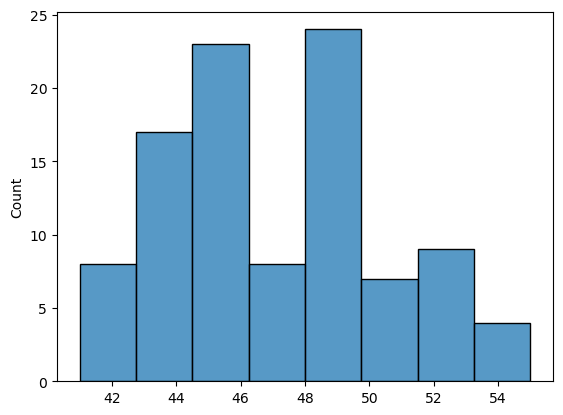

In [23]:
depths = [tree.get_depth() for tree in model_pipeline[-1].regressor_.estimators_]

sns.histplot(depths);

## Modeling Pipeline - With Hyperparameter Tuning

In [30]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CountFrequencyEncoder(unseen='encode',
                                      encoding_method='frequency',
                                      missing_values='ignore'))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))#,
    # ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
    # ('scaler', StandardScaler()),
    # # ('scaler', MinMaxScaler()),
    # ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the TransformedTargetRegressor with Yeo-Johnson transformation
target_transformer = PowerTransformer(method='yeo-johnson')

base_regressor = RandomForestRegressor(n_jobs=-1)

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

# Build the full pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Set up hyperparameter tuning with HalvingGridSearchCV
param_grid = {
    'regressor__regressor__max_depth': [32, 35, 38],
    'regressor__regressor__min_samples_split': [2, 5],
    'regressor__regressor__min_samples_leaf': [2, 4]
}

halving_grid_search = HalvingGridSearchCV(model_pipeline,
                                          param_grid,
                                          scoring='neg_median_absolute_error',
                                          cv=3,
                                          n_jobs=-1,
                                          factor=2,
                                          min_resources="exhaust")

# Fit the model and generate predictions
halving_grid_search.fit(X_train, y_train)

best_model = halving_grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Evaluate performance metrics
score_training = best_model.score(X_train, y_train)
score_testing = best_model.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.2f}\n'
      f'Testing Score: {score_testing:,.2f}\n'
      f'Difference: {score_training - score_testing:,.2f}\n')

mean_ae = metrics.mean_absolute_error(y_test, y_pred)
median_ae = metrics.median_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(



Training Score: 0.89
Testing Score: 0.85
Difference: 0.04

The MAE is $10.61
The MedAE is $5.50
The RMSE is $18.66



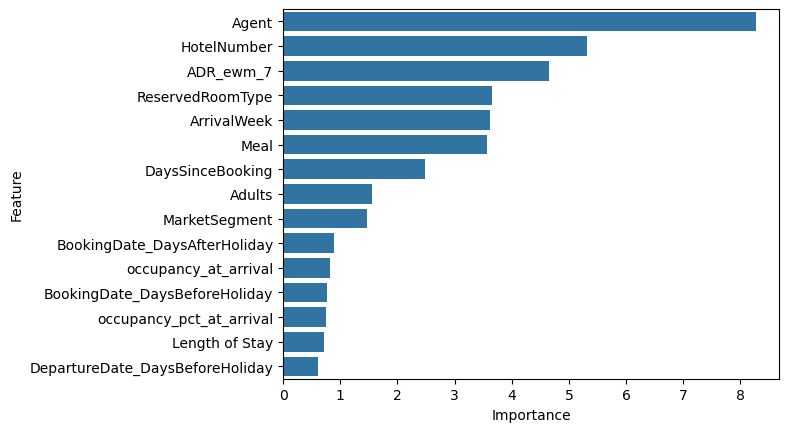

In [31]:
# Calculate permutation importances
result = permutation_importance(halving_grid_search.best_estimator_,
                                X_test, y_test,
                                scoring = 'neg_median_absolute_error',
                                random_state=42,
                                n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:15]);

In [ ]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CountFrequencyEncoder(unseen='encode',
                                      encoding_method='frequency',
                                      missing_values='ignore'))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', fold=3)),
    # ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),
    ('powertransformer', PowerTransformer(method='yeo-johnson'))
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

## ---  Create the TransformedTargetRegressor with Yeo-Johnson transformation --- ##
target_transformer = PowerTransformer(method='yeo-johnson')

base_regressor = HistGradientBoostingRegressor()

regressor = TransformedTargetRegressor(regressor=base_regressor,
                                       transformer=target_transformer)

## --- Build the full pipeline --- ##
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', regressor)])

## --- Fit the model and generate predictions --- ##
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

## --- Evaluate performance metrics --- ##
score_training = model_pipeline.score(X_train, y_train)
score_testing = model_pipeline.score(X_test, y_test)

print(f'\nTraining Score: {score_training:,.3f}\n'
      f'Testing Score: {score_testing:,.3f}\n'
      f'Difference: {score_training - score_testing:,.3f}\n')

mean_ae = metrics.mean_absolute_error(y_pred, y_test)
median_ae = metrics.median_absolute_error(y_pred, y_test)
mse = metrics.mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)


print(f'The MAE is ${mean_ae:,.2f}\n'
      f'The MedAE is ${median_ae:,.2f}\n'
      f'The RMSE is ${rmse:,.2f}\n')